# 301 Final Project- Anime Characters Generator

In this notebook, we compare across the performance of three popular GAN network algorithms:
1. DCGAN
2. WGAN (DCGAN architecture with optimal transport loss (Wasserstein distance))
3. WGAN-GP (DCGAN architecture + Wasserstein distance + gradient penalty technique)

The model perfomance evaluation 

## 1. Import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ML_notes/301_Final_proj/images.zip -d /content/images


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/images/images/52842_2016.jpg  
  inflating: /content/images/images/52843_2016.jpg  
  inflating: /content/images/images/52844_2016.jpg  
  inflating: /content/images/images/52845_2016.jpg  
  inflating: /content/images/images/52846_2016.jpg  
  inflating: /content/images/images/52847_2016.jpg  
  inflating: /content/images/images/52848_2016.jpg  
  inflating: /content/images/images/52849_2016.jpg  
  inflating: /content/images/images/5284_2003.jpg  
  inflating: /content/images/images/52850_2016.jpg  
  inflating: /content/images/images/52851_2016.jpg  
  inflating: /content/images/images/52852_2016.jpg  
  inflating: /content/images/images/52853_2016.jpg  
  inflating: /content/images/images/52854_2016.jpg  
  inflating: /content/images/images/52855_2016.jpg  
  inflating: /content/images/images/52856_2016.jpg  
  inflating: /content/images/images/52857_2016.jpg  
  inflating: /content/images/images/52858_2016.jpg  
  inflating: /conten

## 2. Data Preprocessing

### 1. Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
from numpy import array
from scipy import misc
import os
import numpy as np
%matplotlib inline

### 2. Pipeline for data augmentation & Inspect example input images

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [ ]:
data_dir = '/content/images/'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


train_ds = ImageFolder(data_dir, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

**Visualize some images from original dataset:**

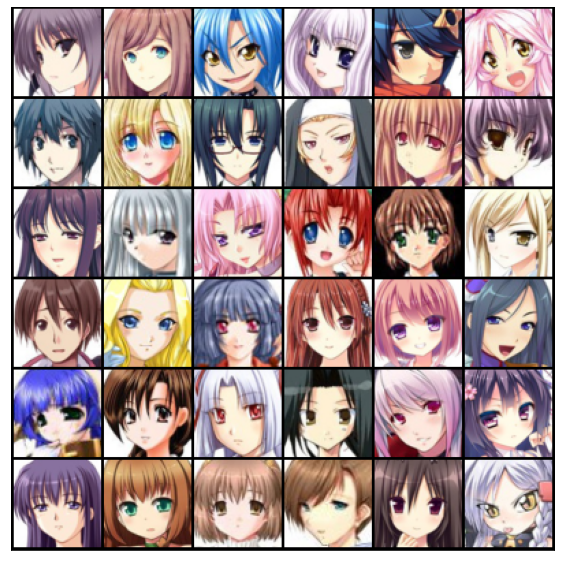

In [ ]:
import torch
from torchvision.utils import make_grid

def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

def show_images(images):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:36]), nrow=6).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

show_batch(train_dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## 3. DCGAN Network

### 1. Construct Generator & Discriminator

In [ ]:
!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#dcgan
import torch.nn as nn

#Generator
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    #512 = ngf * 8
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


#Discriminator
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

torch.Size([128, 3, 64, 64])


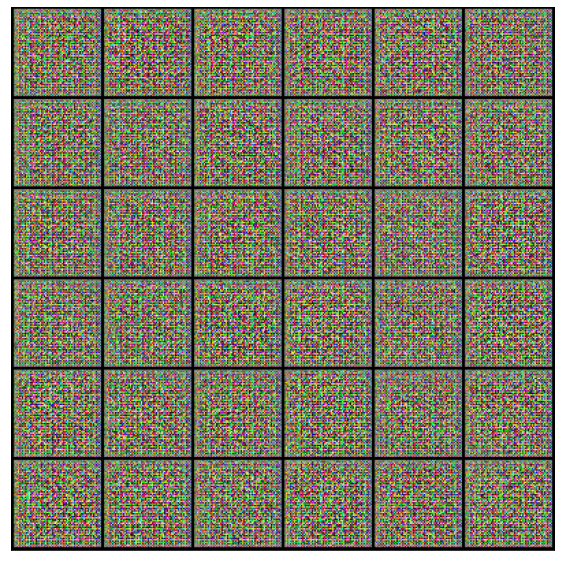

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
#to devices
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [ ]:
print(generator)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)


In [ ]:
print(summary(generator,(latent_size,1,1)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
print(discriminator)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [ ]:
summary(discriminator,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

### 5. Train the neural network



In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated_dcgan'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving 0000.png


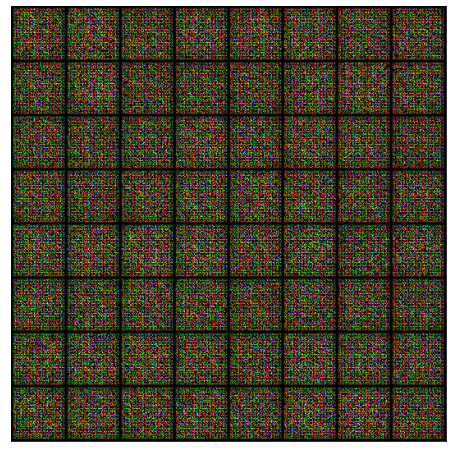

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
#define hyperparams
lr = 0.0002
betas = (0.5, 0.999)
epochs = 10

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            # Train discriminator
            # Clear discriminator gradients
            optimizer_D.zero_grad()

            # Pass real images through discriminator
            real_preds = discriminator(real_images)
            fake_preds = discriminator(fake_images)

            real_targets = torch.ones(real_images.size(0), 1, device=device)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)

            real_loss = F.binary_cross_entropy(real_preds, real_targets)
            real_score = torch.mean(real_preds).item()
            fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()

            optimizer_D.step()

            print(loss_d)
            loss_d = loss_d.item()


            # Clear generator gradients
            optimizer_G.zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            
            # Try to fool the discriminator
            preds = discriminator(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = F.binary_cross_entropy(preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer_G.step()

            loss_g = loss_g.item()
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 7.3953, loss_d: 0.9580, real_score: 0.8628, fake_score: 0.4967
Saving 0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 9.5021, loss_d: 1.0955, real_score: 0.9488, fake_score: 0.5900
Saving 0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 3.8246, loss_d: 0.3182, real_score: 0.8548, fake_score: 0.1213
Saving 0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.3175, loss_d: 0.1684, real_score: 0.8901, fake_score: 0.0395
Saving 0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.7956, loss_d: 0.3090, real_score: 0.9254, fake_score: 0.1844
Saving 0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.3432, loss_d: 0.3383, real_score: 0.7678, fake_score: 0.0102
Saving 0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.2438, loss_d: 0.3345, real_score: 0.9714, fake_score: 0.2369
Saving 0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 4.4215, loss_d: 0.1233, real_score: 0.9309, fake_score: 0.0388
Saving 0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 11.7084, loss_d: 0.9779, real_score: 0.9946, fake_score: 0.5024
Saving 0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.1192, loss_d: 0.1055, real_score: 0.9342, fake_score: 0.0311
Saving 0010.png


In [ ]:
losses_g_dcgan, losses_d_dcgan, real_scores_dcgan, fake_scores_dcgan = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

## 3. Visualize the training procedure & Display the outputs

In [ ]:
import matplotlib.animation as anim
from IPython.display import HTML

In [ ]:
output_dir = '/content/generated_dcgan'

In [ ]:
imgs = sorted([
    f for f in os.listdir(output_dir) 
    if f.endswith(".png")], key=lambda x: int(x[:-4]))

ims = []

fig = plt.figure(figsize=(6, 6))

for f in imgs:
    ims.append([plt.imshow(plt.imread(os.path.join(output_dir, f)), animated=True)])

plt.axis("off")

ani = anim.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### 4. Evaluation & Explaination


In [ ]:
#personal preferences:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

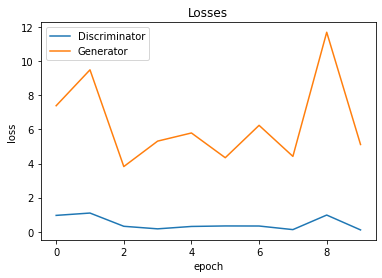

In [ ]:
plt.plot(losses_d_dcgan, '-')
plt.plot(losses_g_dcgan, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

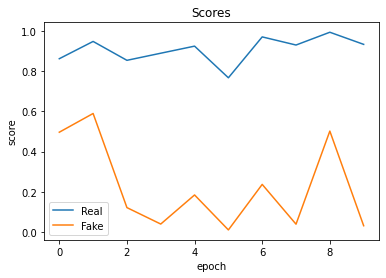

In [ ]:
plt.plot(real_scores_dcgan, '-')
plt.plot(fake_scores_dcgan, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');